In [2]:
from datasets import load_dataset

c:\Users\guisa\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Empezamos con 5000 datos
dataset = load_dataset("ag_news", split="train[:5000]")

# Ejemplo
print("Ejemplo de datos cargados:")
print(dataset[0])

Ejemplo de datos cargados:
{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.", 'label': 2}


In [4]:
# Estadísticas de los datos
labels = dataset.features["label"].names
print("\nEtiquetas de los datos:", labels)


Etiquetas de los datos: ['World', 'Sports', 'Business', 'Sci/Tech']


In [5]:
# Conteo de cada etiqueta
from collections import Counter
counts = Counter([labels[x["label"]] for x in dataset])
print("\nConteo de cada etiqueta:", counts) 


Conteo de cada etiqueta: Counter({'Sci/Tech': 1497, 'Business': 1236, 'World': 1235, 'Sports': 1032})


## Preprocesamiento
---

In [6]:
import nltk
import re
from nltk.corpus import stopwords

In [7]:
nltk.download("stopwords")
stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guisa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    tokens = text.split()
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

In [9]:
# Preprocesamos los datos
text = [preprocess(example["text"]) for example in dataset]

print("\nEjemplo de texto preprocesado:")
print(text[0])


Ejemplo de texto preprocesado:
['wall', 'st', 'bears', 'claw', 'back', 'black', 'reuters', 'reuters', 'shortsellers', 'wall', 'streets', 'dwindlingband', 'ultracynics', 'seeing', 'green']


## TF-IDF
---

[ ] Code provisional TODO

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [11]:
# Convertimos los token preprocesados a texto limpio
clean_text = [" ".join(t) for t in text]

# Vectorizacion TF-IDF
vectorizer = TfidfVectorizer(max_features=3000)
X_tfidf = vectorizer.fit_transform(clean_text)

print("\nDimensiones de la matriz TF-IDF:", X_tfidf.shape)
print("Primeros 10 terminos del vocabulario:")
print(list(vectorizer.vocabulary_.keys())[:10])


Dimensiones de la matriz TF-IDF: (5000, 3000)
Primeros 10 terminos del vocabulario:
['wall', 'st', 'back', 'black', 'reuters', 'streets', 'seeing', 'green', 'looks', 'toward']


### Visualizción términos más frecuentes

In [12]:
import numpy as np
import pandas as pd

# Calcular TF-IDF promedio por término
mean_tfidf = np.asarray(X_tfidf.mean(axis=0)).flatten()
terms = vectorizer.get_feature_names_out()

# Crear tabla y ordenar
df_tfidf = pd.DataFrame({"term": terms, "avg_tfidf": mean_tfidf})
top_terms = df_tfidf.sort_values(by="avg_tfidf", ascending=False).head(20)
print(top_terms)

           term  avg_tfidf
2207    reuters   0.023289
128          ap   0.022766
2815         us   0.020208
1739        new   0.019059
2271       said   0.015827
1085     google   0.012393
177      athens   0.011755
2767    tuesday   0.011667
1786        oil   0.011651
969       first   0.010992
2907  wednesday   0.010756
1256        inc   0.009802
530     company   0.009507
2004     prices   0.009407
2782        two   0.009384
2698   thursday   0.009139
1790    olympic   0.009083
2992       york   0.008184
1078       gold   0.008090
2964      world   0.008046


### Matriz de coocurrencias y PMI


In [13]:
from collections import Counter, defaultdict
import itertools

- Creamos la matriz de coocurrencisa para hallar aquellas palabras que aparezcan juntas en un mismo contexto.

In [14]:
window_size = 4
cooccurrence_counts = defaultdict(Counter)

for tokens in text:
    for i, token in enumerate(tokens):
        window = tokens[max(i - window_size, 0): i] + tokens[i+1: i+1+window_size]
        for neighbor in window:
            cooccurrence_counts[token][neighbor] += 1

In [15]:
import math

# Conteos totales
word_counts = Counter(itertools.chain(*text))
total_words = sum(word_counts.values())

def compute_pmi(word, context):
    pw = word_counts[word] / total_words
    pc = word_counts[context] / total_words
    pwc = cooccurrence_counts[word][context] / total_words
    if pwc == 0:
        return 0
    return math.log2(pwc / (pw * pc))

# Tabla PMI ejemplo
sample_words = ["president", "game", "company", "computer"]
for word in sample_words:
    print(f"\nPalabras relacionadas con '{word}':")
    related = [(w, compute_pmi(word, w)) for w in cooccurrence_counts[word]]
    related = sorted(related, key=lambda x: -x[1])[:10]
    for neighbor, score in related:
        print(f"  {neighbor}: {score:.2f}")



Palabras relacionadas con 'president':
  gleam: 9.57
  unitedstatesi: 9.57
  unelectable: 9.57
  corporationand: 9.57
  nominees: 9.57
  anexecutive: 9.57
  ingrained: 9.57
  distrustof: 9.57
  concentrated: 9.57
  referendumthat: 9.57

Palabras relacionadas con 'game':
  ballpark: 11.20
  whotold: 10.20
  microgames: 10.20
  catwoman: 10.20
  mosquitos: 10.20
  gamecopying: 10.20
  fiftyfive: 10.20
  dislocating: 10.20
  forthcoming: 10.20
  convergence: 10.20

Palabras relacionadas con 'company':
  exemployees: 9.50
  marlboroughbased: 9.50
  ecm: 9.50
  anoil: 9.50
  picnic: 9.50
  sidestepped: 8.50
  shuts: 8.50
  clockwork: 8.50
  wrests: 8.50
  defunct: 8.50

Palabras relacionadas con 'computer':
  unfortunately: 11.19
  makerdell: 10.19
  locks: 10.19
  toggle: 10.19
  problemsolving: 10.19
  teambuilding: 10.19
  treats: 10.19
  contamination: 10.19
  resellers: 10.19
  interrupted: 10.19


### Matriz PMI


[ ] TODO - fix
- Realizamos el PMI para la matriz completa en lugar de solo unas palabras

In [16]:
# 50 palabras más frecuentes
top_words = [word for word, freq in word_counts.most_common(50)]

pmi_matrix = pd.DataFrame(index=top_words, columns=top_words)

# Cálculo de PMI para cada par de palabras
for w1 in top_words:
    for w2 in top_words:
        pw = word_counts[w1] / total_words
        pc = word_counts[w2] / total_words
        pwc = cooccurrence_counts[w1][w2] / total_words

        # Calcular PMI solo si hay coocurrencia
        if pwc > 0:
            pmi = np.log2(pwc / (pw * pc))
            pmi_matrix.at[w1, w2] = pmi
        else:
            pmi_matrix.at[w1, w2] = 0

pmi_matrix = pmi_matrix.astype(float)
display(pmi_matrix.head())


,reuters,us,ap,new,said,tuesday,wednesday,google,first,athens,...,week,yesterday,games,says,corp,home,price,security,stocks,ipo
reuters,5.332438,4.251320,0.000000,4.648810,2.281694,2.273132,1.147316,4.171511,1.534460,4.870095,...,2.066681,0.000000,2.540986,1.418510,4.556014,3.689118,3.689118,0.712079,5.264135,3.897517
us,4.251320,1.015220,2.797561,3.616484,3.221671,3.814013,3.188271,1.068536,2.515914,3.089049,...,2.555095,2.392587,0.400043,3.502534,1.736999,2.882076,1.007607,1.445606,5.125767,2.631044
ap,0.000000,2.797561,6.814960,2.722793,1.801665,1.841466,1.341255,2.095989,3.050327,1.631075,...,1.734551,0.000000,1.427496,1.442524,2.764453,2.257453,-0.549902,1.058021,0.480794,2.073534
new,4.648810,3.616484,2.722793,3.436207,1.899743,1.832629,2.076763,4.168072,1.715445,-0.007813,...,2.095663,2.518118,0.525574,1.540602,3.241042,3.635638,3.940493,3.030568,5.411762,4.110211
said,2.281694,3.221671,1.801665,1.899743,0.199303,5.505891,5.157683,0.560741,1.152509,-0.418746,...,3.684730,4.779610,-0.300397,0.000000,4.299594,2.307167,0.000000,3.204597,-0.247098,0.760679


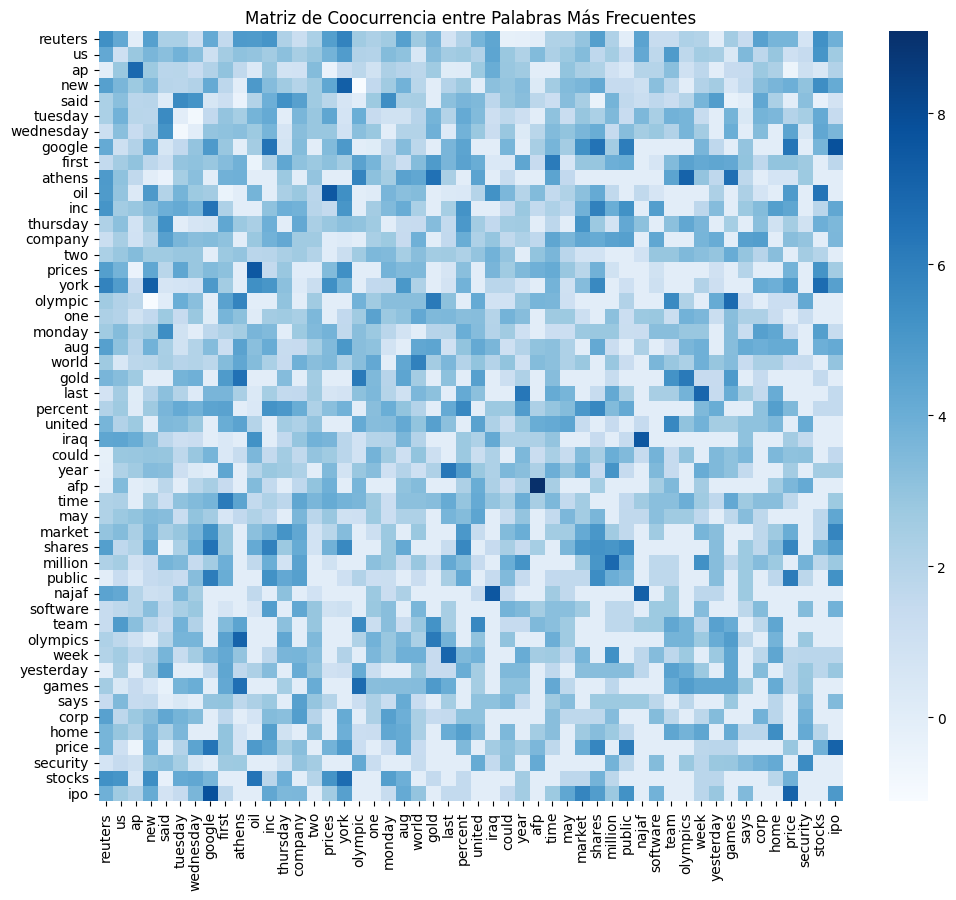

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,10))
sns.heatmap(pmi_matrix, cmap="Blues", annot=False)
plt.title("Matriz de Coocurrencia entre Palabras Más Frecuentes")
plt.show()

### Palabrs similares con PMI


- Dada una palabra, buscamos las 5 palabras más similares basado en los valores PIM.

In [22]:
def find_similar_words(target, pmi_matrix, top_n=5):
    if target not in pmi_matrix.index:
        print(f"'{target}' no se encuentra en la matriz.")
        return []

    similar_words = pmi_matrix[target]
    similar_words = similar_words.drop(target)  # eliminar comparación consigo mismo
    top_similar = similar_words.sort_values(ascending=False).head(top_n)
    
    return top_similar

In [23]:
target_words = ["yesterday", "olympics", "world", "google"]

for target in target_words:
    print(f"\nPalabras similares a '{target}' según PMI:")
    similar = find_similar_words(target, pmi_matrix, top_n=5)
    print(similar)


Palabras similares a 'yesterday' según PMI:
said       4.779610
team       4.547865
games      4.362373
first      4.345793
olympic    4.136247
Name: yesterday, dtype: float64

Palabras similares a 'olympics' según PMI:
athens      7.079865
gold        6.212569
games       4.755271
first       4.530105
thursday    4.299365
Name: olympics, dtype: float64

Palabras similares a 'world' según PMI:
aug        4.291660
athens     4.280347
one        4.228696
company    3.891447
week       3.881323
Name: world, dtype: float64

Palabras similares a 'google' según PMI:
ipo       7.794542
inc       6.447615
shares    6.441624
price     6.341031
public    6.072103
Name: google, dtype: float64
